## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [1e-2, 1e-3, 1e-5, 1e-8]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.01, reduce_patient: 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

Epoch 10/25
49/49 [==============================] - 2s 36ms/step - loss: 1.3400 - accuracy: 0.5309 - val_loss: 1.5140 - val_accuracy: 0.4647 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3142 - accuracy: 0.5408 - val_loss: 1.4929 - val_accuracy: 0.4726 - lr: 0.0010
Epoch 12/25
49/49 [==============================] - 2s 38ms/step - loss: 1.2894 - accuracy: 0.5494 - val_loss: 1.4909 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 13/25
49/49 [==============================] - 2s 38ms/step - loss: 1.2685 - accuracy: 0.5557 - val_loss: 1.4991 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 14/25
49/49 [==============================] - 2s 38ms/step - loss: 1.2453 - accuracy: 0.5659 - val_loss: 1.4775 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 15/25
49/49 [==============================] - 2s 37ms/step - loss: 1.2230 - accuracy: 0.5750 - val_loss: 1.4779 - val_accuracy: 0.4820 - lr: 0.0010
Epoch 16/25
49/49 [==============================] - 2s 39ms/step - lo

Epoch 1/25
49/49 [==============================] - 2s 38ms/step - loss: 2.2396 - accuracy: 0.2653 - val_loss: 2.1937 - val_accuracy: 0.1529 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 2s 36ms/step - loss: 1.7839 - accuracy: 0.3832 - val_loss: 2.0090 - val_accuracy: 0.2732 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 2s 35ms/step - loss: 1.6492 - accuracy: 0.4242 - val_loss: 1.8654 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 2s 36ms/step - loss: 1.5707 - accuracy: 0.4507 - val_loss: 1.7567 - val_accuracy: 0.3846 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 35ms/step - loss: 1.5156 - accuracy: 0.4689 - val_loss: 1.6692 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 2s 36ms/step - loss: 1.4692 - accuracy: 0.4858 - val_loss: 1.5986 - val_accuracy: 0.4379 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 2s 36ms/step - loss: 1.4

49/49 [==============================] - 2s 38ms/step - loss: 1.1649 - accuracy: 0.5975 - val_loss: 1.4515 - val_accuracy: 0.4891 - lr: 0.0010
Epoch 20/25
49/49 [==============================] - 2s 37ms/step - loss: 1.1470 - accuracy: 0.6046 - val_loss: 1.4488 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 21/25
49/49 [==============================] - 2s 40ms/step - loss: 1.1308 - accuracy: 0.6119 - val_loss: 1.4388 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 22/25
49/49 [==============================] - 2s 47ms/step - loss: 1.1138 - accuracy: 0.6161 - val_loss: 1.4477 - val_accuracy: 0.4878 - lr: 0.0010
Epoch 23/25
49/49 [==============================] - 2s 41ms/step - loss: 1.0986 - accuracy: 0.6229 - val_loss: 1.4438 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 24/25
49/49 [==============================] - 2s 43ms/step - loss: 1.0798 - accuracy: 0.6307 - val_loss: 1.4487 - val_accuracy: 0.4913 - lr: 0.0010
Epoch 25/25
49/49 [==============================] - 2s 41ms/step - loss: 1.0647 -

49/49 [==============================] - 2s 40ms/step - loss: 1.6367 - accuracy: 0.4260 - val_loss: 1.8465 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5646 - accuracy: 0.4504 - val_loss: 1.7404 - val_accuracy: 0.3968 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 38ms/step - loss: 1.5079 - accuracy: 0.4703 - val_loss: 1.6431 - val_accuracy: 0.4309 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 2s 37ms/step - loss: 1.4661 - accuracy: 0.4854 - val_loss: 1.5984 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4283 - accuracy: 0.4978 - val_loss: 1.5670 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 8/25
49/49 [==============================] - 2s 37ms/step - loss: 1.3973 - accuracy: 0.5090 - val_loss: 1.5251 - val_accuracy: 0.4617 - lr: 0.0010
Epoch 9/25
49/49 [==============================] - 2s 37ms/step - loss: 1.3664 - accur

49/49 [==============================] - 2s 39ms/step - loss: 1.1128 - accuracy: 0.6171 - val_loss: 1.4615 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 22/25
49/49 [==============================] - 2s 40ms/step - loss: 1.0952 - accuracy: 0.6244 - val_loss: 1.4396 - val_accuracy: 0.4990 - lr: 0.0010
Epoch 23/25
49/49 [==============================] - 2s 38ms/step - loss: 1.0762 - accuracy: 0.6331 - val_loss: 1.4432 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 24/25
49/49 [==============================] - 2s 38ms/step - loss: 1.0612 - accuracy: 0.6391 - val_loss: 1.4461 - val_accuracy: 0.5019 - lr: 0.0010
Epoch 25/25
49/49 [==============================] - 2s 37ms/step - loss: 1.0440 - accuracy: 0.6450 - val_loss: 1.4433 - val_accuracy: 0.5005 - lr: 0.0010
Numbers of exp: 8, reduce_factor: 0.01, reduce_patient: 5
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [

49/49 [==============================] - 2s 38ms/step - loss: 1.7863 - accuracy: 0.3843 - val_loss: 1.9808 - val_accuracy: 0.2930 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 38ms/step - loss: 1.7229 - accuracy: 0.4019 - val_loss: 1.8794 - val_accuracy: 0.3332 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 37ms/step - loss: 1.6769 - accuracy: 0.4178 - val_loss: 1.7857 - val_accuracy: 0.3715 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 37ms/step - loss: 1.6408 - accuracy: 0.4298 - val_loss: 1.7222 - val_accuracy: 0.3922 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 38ms/step - loss: 1.6125 - accuracy: 0.4391 - val_loss: 1.6918 - val_accuracy: 0.4054 - lr: 1.0000e-05
Epoch 8/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5880 - accuracy: 0.4478 - val_loss: 1.6626 - val_accuracy: 0.4103 - lr: 1.0000e-05
Epoch 9/25
49/49 [==============================] - 2s 40ms/ste

49/49 [==============================] - 2s 38ms/step - loss: 1.4148 - accuracy: 0.5045 - val_loss: 1.5841 - val_accuracy: 0.4513 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 38ms/step - loss: 1.4062 - accuracy: 0.5083 - val_loss: 1.5776 - val_accuracy: 0.4538 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3975 - accuracy: 0.5107 - val_loss: 1.5733 - val_accuracy: 0.4542 - lr: 1.0000e-05
Epoch 23/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3891 - accuracy: 0.5142 - val_loss: 1.5678 - val_accuracy: 0.4570 - lr: 1.0000e-05
Epoch 24/25
49/49 [==============================] - 2s 37ms/step - loss: 1.3804 - accuracy: 0.5173 - val_loss: 1.5671 - val_accuracy: 0.4555 - lr: 1.0000e-05
Epoch 25/25
49/49 [==============================] - 2s 37ms/step - loss: 1.3729 - accuracy: 0.5210 - val_loss: 1.5634 - val_accuracy: 0.4555 - lr: 1.0000e-05
Numbers of exp: 11, reduce_factor: 0.00, reduce_patient: 1

49/49 [==============================] - 2s 39ms/step - loss: 1.7436 - accuracy: 0.3969 - val_loss: 1.9069 - val_accuracy: 0.3324 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 39ms/step - loss: 1.6830 - accuracy: 0.4169 - val_loss: 1.8007 - val_accuracy: 0.3693 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 40ms/step - loss: 1.6409 - accuracy: 0.4306 - val_loss: 1.7197 - val_accuracy: 0.3946 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 39ms/step - loss: 1.6094 - accuracy: 0.4425 - val_loss: 1.6772 - val_accuracy: 0.4108 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5812 - accuracy: 0.4513 - val_loss: 1.6504 - val_accuracy: 0.4152 - lr: 1.0000e-05
Epoch 8/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5586 - accuracy: 0.4584 - val_loss: 1.6392 - val_accuracy: 0.4212 - lr: 1.0000e-05
Epoch 9/25
49/49 [==============================] - 2s 39ms/ste

49/49 [==============================] - 2s 39ms/step - loss: 1.3968 - accuracy: 0.5130 - val_loss: 1.5831 - val_accuracy: 0.4436 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3872 - accuracy: 0.5164 - val_loss: 1.5784 - val_accuracy: 0.4486 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 37ms/step - loss: 1.3777 - accuracy: 0.5203 - val_loss: 1.5759 - val_accuracy: 0.4462 - lr: 1.0000e-05
Epoch 23/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3694 - accuracy: 0.5226 - val_loss: 1.5699 - val_accuracy: 0.4515 - lr: 1.0000e-05
Epoch 24/25
49/49 [==============================] - 2s 38ms/step - loss: 1.3608 - accuracy: 0.5265 - val_loss: 1.5684 - val_accuracy: 0.4548 - lr: 1.0000e-05
Epoch 25/25
49/49 [==============================] - 2s 39ms/step - loss: 1.3532 - accuracy: 0.5295 - val_loss: 1.5615 - val_accuracy: 0.4557 - lr: 1.0000e-05
Numbers of exp: 14, reduce_factor: 0.00, reduce_patient: 5

49/49 [==============================] - 2s 38ms/step - loss: 1.7602 - accuracy: 0.3899 - val_loss: 1.9437 - val_accuracy: 0.3070 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 39ms/step - loss: 1.6974 - accuracy: 0.4109 - val_loss: 1.8245 - val_accuracy: 0.3670 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 39ms/step - loss: 1.6518 - accuracy: 0.4254 - val_loss: 1.7431 - val_accuracy: 0.3890 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 38ms/step - loss: 1.6180 - accuracy: 0.4386 - val_loss: 1.6966 - val_accuracy: 0.4041 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 39ms/step - loss: 1.5889 - accuracy: 0.4464 - val_loss: 1.6683 - val_accuracy: 0.4094 - lr: 1.0000e-05
Epoch 8/25
49/49 [==============================] - 2s 38ms/step - loss: 1.5638 - accuracy: 0.4563 - val_loss: 1.6498 - val_accuracy: 0.4174 - lr: 1.0000e-05
Epoch 9/25
49/49 [==============================] - 2s 38ms/ste

Epoch 20/25
49/49 [==============================] - 2s 42ms/step - loss: 0.9378 - accuracy: 0.6795 - val_loss: 1.2681 - val_accuracy: 0.5506 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 42ms/step - loss: 0.9360 - accuracy: 0.6807 - val_loss: 1.2678 - val_accuracy: 0.5496 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 42ms/step - loss: 0.9334 - accuracy: 0.6811 - val_loss: 1.2677 - val_accuracy: 0.5507 - lr: 1.0000e-05
Epoch 23/25
49/49 [==============================] - 2s 42ms/step - loss: 0.9313 - accuracy: 0.6820 - val_loss: 1.2683 - val_accuracy: 0.5499 - lr: 1.0000e-05
Epoch 24/25
49/49 [==============================] - 2s 41ms/step - loss: 0.9291 - accuracy: 0.6833 - val_loss: 1.2679 - val_accuracy: 0.5510 - lr: 1.0000e-05
Epoch 25/25
49/49 [==============================] - 2s 41ms/step - loss: 0.9284 - accuracy: 0.6840 - val_loss: 1.2681 - val_accuracy: 0.5513 - lr: 1.0000e-05
Numbers of exp: 17, reduce_factor: 0.01, reduc

49/49 [==============================] - 2s 43ms/step - loss: 2.0982 - accuracy: 0.2947 - val_loss: 2.0822 - val_accuracy: 0.2290 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 43ms/step - loss: 1.9993 - accuracy: 0.3196 - val_loss: 2.0014 - val_accuracy: 0.2684 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 43ms/step - loss: 1.9263 - accuracy: 0.3399 - val_loss: 1.9276 - val_accuracy: 0.3040 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 42ms/step - loss: 1.8703 - accuracy: 0.3548 - val_loss: 1.8754 - val_accuracy: 0.3318 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 42ms/step - loss: 1.8225 - accuracy: 0.3695 - val_loss: 1.8203 - val_accuracy: 0.3553 - lr: 1.0000e-05
Epoch 8/25
49/49 [==============================] - 2s 42ms/step - loss: 1.7847 - accuracy: 0.3833 - val_loss: 1.7994 - val_accuracy: 0.3640 - lr: 1.0000e-05
Epoch 9/25
49/49 [==============================] - 2s 44ms/ste

49/49 [==============================] - 2s 40ms/step - loss: 1.5598 - accuracy: 0.4560 - val_loss: 1.6779 - val_accuracy: 0.4149 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5459 - accuracy: 0.4615 - val_loss: 1.6757 - val_accuracy: 0.4145 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 42ms/step - loss: 1.5354 - accuracy: 0.4652 - val_loss: 1.6622 - val_accuracy: 0.4182 - lr: 1.0000e-05
Epoch 23/25
49/49 [==============================] - 2s 42ms/step - loss: 1.5228 - accuracy: 0.4699 - val_loss: 1.6553 - val_accuracy: 0.4193 - lr: 1.0000e-05
Epoch 24/25
49/49 [==============================] - 2s 43ms/step - loss: 1.5121 - accuracy: 0.4732 - val_loss: 1.6510 - val_accuracy: 0.4235 - lr: 1.0000e-05
Epoch 25/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5016 - accuracy: 0.4783 - val_loss: 1.6455 - val_accuracy: 0.4257 - lr: 1.0000e-05
Numbers of exp: 20, reduce_factor: 0.00, reduce_patient: 5

49/49 [==============================] - 2s 41ms/step - loss: 2.1018 - accuracy: 0.2922 - val_loss: 2.0702 - val_accuracy: 0.2612 - lr: 1.0000e-05
Epoch 4/25
49/49 [==============================] - 2s 41ms/step - loss: 1.9988 - accuracy: 0.3189 - val_loss: 1.9776 - val_accuracy: 0.3003 - lr: 1.0000e-05
Epoch 5/25
49/49 [==============================] - 2s 46ms/step - loss: 1.9264 - accuracy: 0.3384 - val_loss: 1.9084 - val_accuracy: 0.3210 - lr: 1.0000e-05
Epoch 6/25
49/49 [==============================] - 2s 41ms/step - loss: 1.8705 - accuracy: 0.3535 - val_loss: 1.8612 - val_accuracy: 0.3353 - lr: 1.0000e-05
Epoch 7/25
49/49 [==============================] - 2s 43ms/step - loss: 1.8244 - accuracy: 0.3691 - val_loss: 1.8193 - val_accuracy: 0.3509 - lr: 1.0000e-05
Epoch 8/25
49/49 [==============================] - 2s 44ms/step - loss: 1.7875 - accuracy: 0.3782 - val_loss: 1.7921 - val_accuracy: 0.3652 - lr: 1.0000e-05
Epoch 9/25
49/49 [==============================] - 2s 41ms/ste

49/49 [==============================] - 2s 43ms/step - loss: 1.5513 - accuracy: 0.4566 - val_loss: 1.6703 - val_accuracy: 0.4141 - lr: 1.0000e-05
Epoch 21/25
49/49 [==============================] - 2s 45ms/step - loss: 1.5387 - accuracy: 0.4617 - val_loss: 1.6622 - val_accuracy: 0.4184 - lr: 1.0000e-05
Epoch 22/25
49/49 [==============================] - 2s 43ms/step - loss: 1.5273 - accuracy: 0.4662 - val_loss: 1.6576 - val_accuracy: 0.4203 - lr: 1.0000e-05
Epoch 23/25
49/49 [==============================] - 2s 42ms/step - loss: 1.5153 - accuracy: 0.4706 - val_loss: 1.6479 - val_accuracy: 0.4239 - lr: 1.0000e-05
Epoch 24/25
49/49 [==============================] - 2s 41ms/step - loss: 1.5038 - accuracy: 0.4742 - val_loss: 1.6406 - val_accuracy: 0.4261 - lr: 1.0000e-05
Epoch 25/25
49/49 [==============================] - 2s 40ms/step - loss: 1.4941 - accuracy: 0.4777 - val_loss: 1.6339 - val_accuracy: 0.4288 - lr: 1.0000e-05
Numbers of exp: 23, reduce_factor: 0.00, reduce_patient: 1

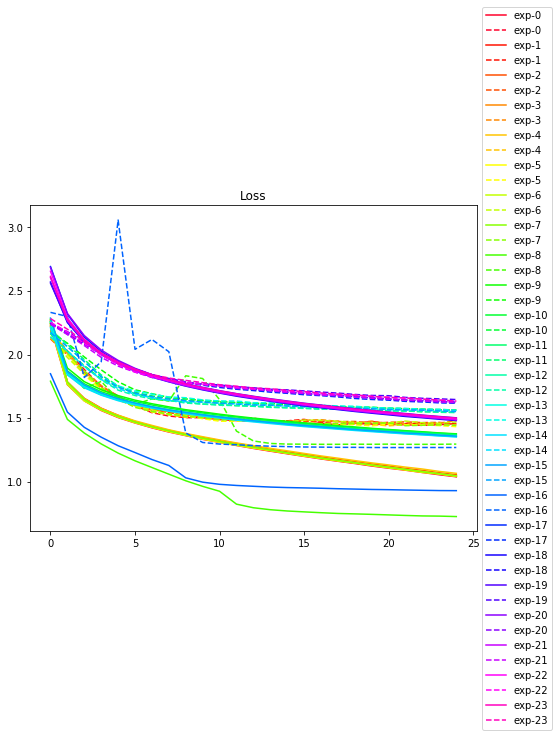

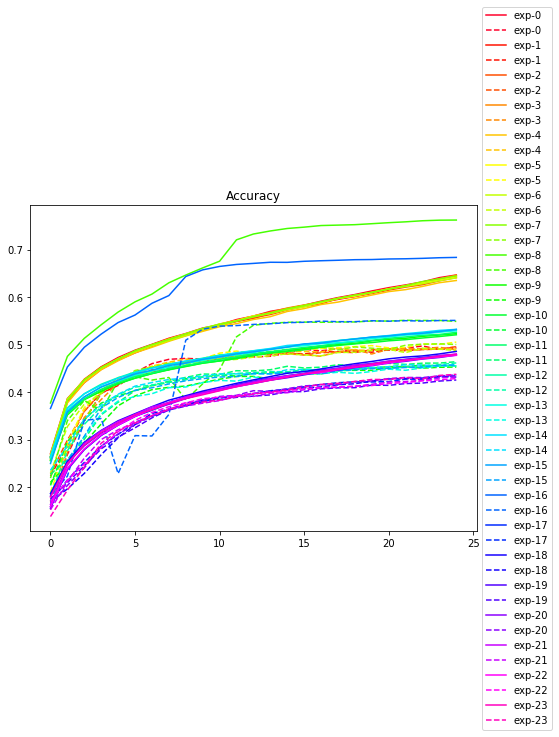

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()